<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

O problema identificado reside na subutilização da capacidade máxima dos veículos da empresa Loggi no Distrito Federal, especialmente nas áreas mais distantes dos centros urbanos. Ao criar dataframes e gráficos, ficou evidente que muitos veículos não estão operando com sua capacidade máxima, especialmente em regiões periféricas. Isso sugere ineficiências na roteirização ou planejamento logístico, resultando em custos adicionais e subaproveitamento dos recursos da empresa.

## 2\. Pacotes e bibliotecas

In [1]:
import json

import geopy

from geopy.geocoders import Nominatim

from geopy.extra.rate_limiter import RateLimiter

import matplotlib.pyplot as plt

from itertools import combinations

from geopy.distance import geodesic

import numpy as np

import seaborn as sns

import pandas as pd

!pip3 install geopandas;

import geopandas

!pip install folium

import folium

## 3\. Exploração de dados

In [2]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

In [3]:
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

deliveries_df = pd.DataFrame(data)

hub_origin_df = pd.json_normalize(deliveries_df["origin"])

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


## 4\. Manipulação

A geocodificação é o processo que transforma uma localização descrita por um texto (endereço, nome do local, etc.) em sua respectiva coodernada geográfica (latitude e longitude). A geocodificação reversa faz o oposto, transforma uma coordenada geográfica de um local em suas respectivas descrições textuais.
Vamos então aplicar a geocodificação nas coordenadas das três regiões e extrair informações de cidade e bairro.

In [4]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)

geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)

hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.100010,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [5]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

<ipython-input-5-e7ffd1c368d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
<ipython-input-5-e7ffd1c368d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
<ipython-input-5-e7ffd1c368d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [6]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [7]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


In [8]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [9]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [10]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [11]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [12]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [13]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [14]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


## 5\. Visualização

Fizemos o download dos dados do mapa do Distrito Federal do site oficial do IBGE para criar o DataFrame mapa e agora vamos utilizar essas informações para uma melhor visualização da logistica aplicada pela empresa.

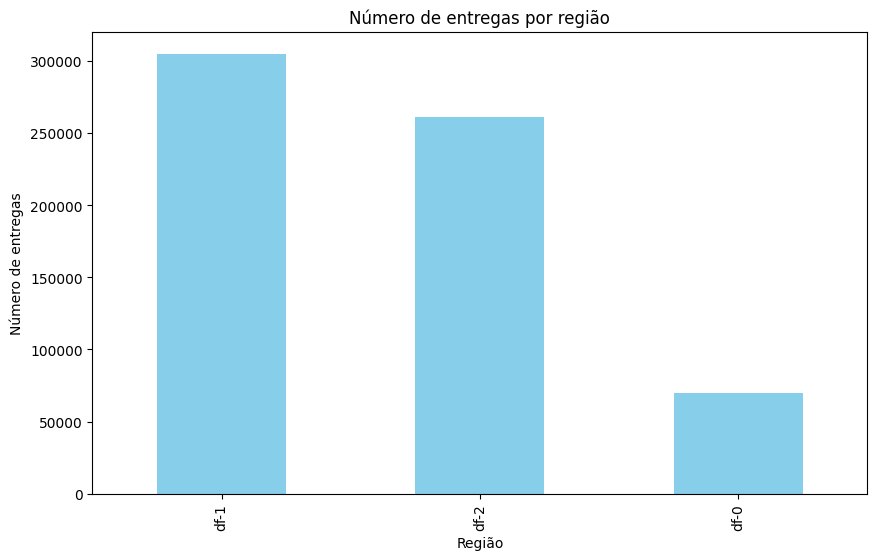

In [15]:
plt.figure(figsize=(10, 6))
geo_deliveries_df['region'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Número de entregas por região')
plt.xlabel('Região')
plt.ylabel('Número de entregas')
plt.show()

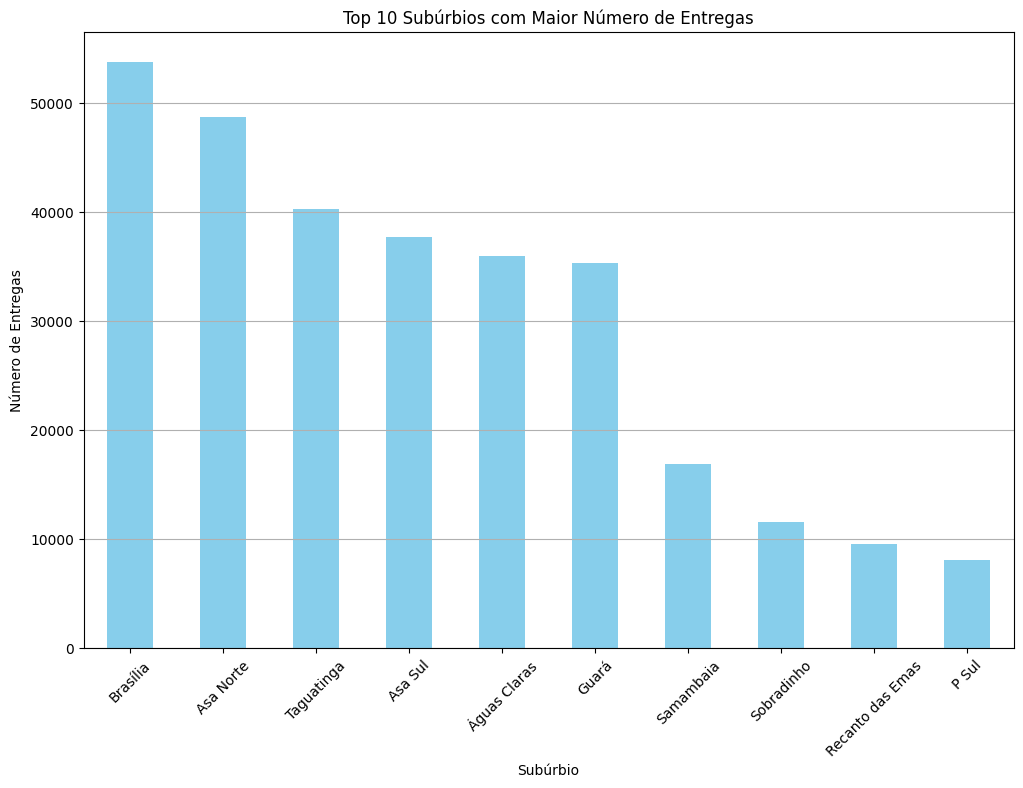

In [16]:
entregas_por_suburbio = geo_deliveries_df['delivery_suburb'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
entregas_por_suburbio.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Subúrbios com Maior Número de Entregas')
plt.xlabel('Subúrbio')
plt.ylabel('Número de Entregas')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Durante a análise dos dados logísticos, observamos uma tendência preocupante: muitos veículos estão saindo para entregas sem aproveitar sua capacidade máxima de carga. Especificamente, ao examinar o gráfico, podemos identificar claramente os subúrbios onde os veículos estão operando com menos de 75% da capacidade total de carga. Essa subutilização dos recursos não apenas resulta em eficiência logística reduzida, mas também pode levar a custos adicionais e impactos ambientais negativos devido a viagens desnecessárias. Identificar essas áreas nos permite direcionar estratégias de otimização de roteirização e alocação de recursos, visando maximizar a eficiência operacional e minimizar desperdícios.

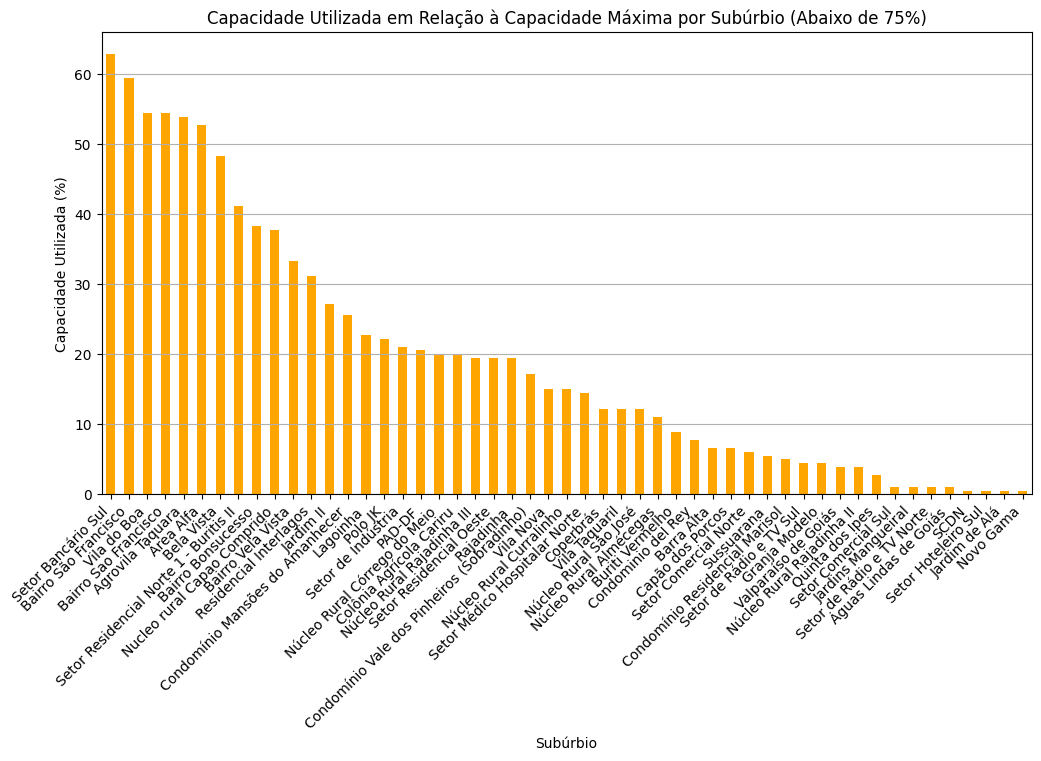

In [17]:
capacidade_utilizada_percent = (entregas_por_suburbio / geo_deliveries_df['vehicle_capacity'].iloc[0]) * 100

suburbios_abaixo_de_75_percent = capacidade_utilizada_percent[capacidade_utilizada_percent < 75]

plt.figure(figsize=(12, 6))
suburbios_abaixo_de_75_percent.plot(kind='bar', color='orange')
plt.title('Capacidade Utilizada em Relação à Capacidade Máxima por Subúrbio (Abaixo de 75%)')
plt.xlabel('Subúrbio')
plt.ylabel('Capacidade Utilizada (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

Ao analisar o gráfico que destaca os 15 subúrbios com o menor aproveitamento dos veículos, fica evidente que essas áreas representam pontos críticos de ineficiência na operação logística da empresa. Esses subúrbios específicos são onde os veículos estão operando com uma utilização significativamente abaixo do esperado, o que indica possíveis problemas de roteirização, demanda de entrega ou alocação de recursos. Essa análise direcionada nos permite identificar áreas específicas para intervenção e melhoria, seja através de ajustes nos roteiros de entrega, aumento da demanda por meio de estratégias de marketing localizado ou realocação de recursos para atender melhor essas regiões. Ao focar nesses 15 subúrbios com o menor aproveitamento, podemos implementar medidas corretivas direcionadas para otimizar a eficiência da operação logística e melhorar a satisfação do cliente.

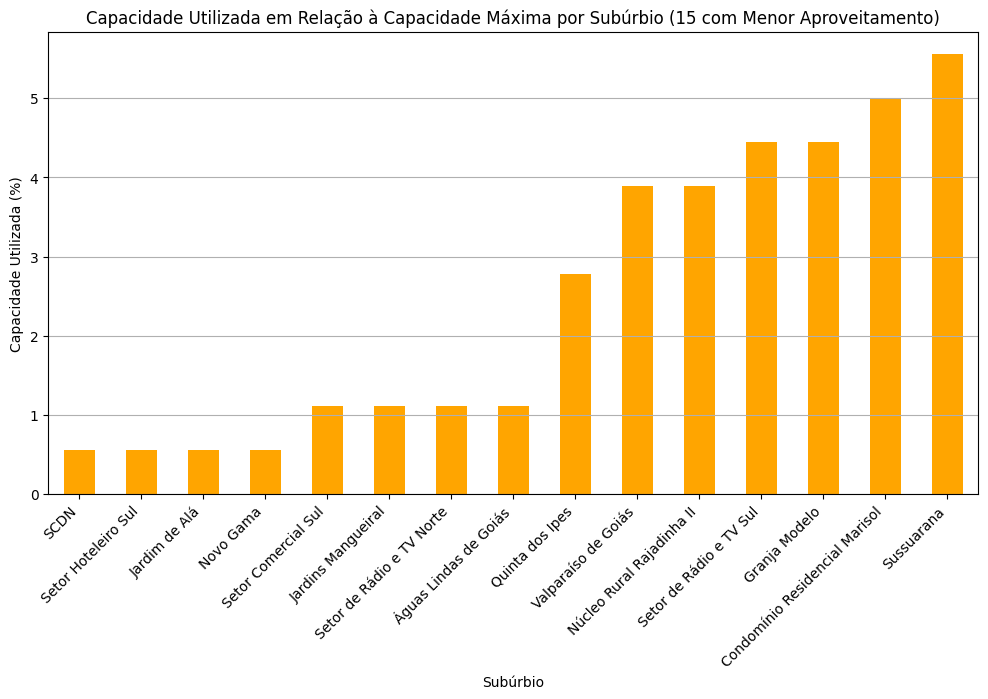

In [18]:
capacidade_utilizada_percent = (entregas_por_suburbio / geo_deliveries_df['vehicle_capacity'].iloc[0]) * 100

suburbios_abaixo_de_75_percent = capacidade_utilizada_percent[capacidade_utilizada_percent < 75]

suburbios_menor_aproveitamento = suburbios_abaixo_de_75_percent.nsmallest(15)

plt.figure(figsize=(12, 6))
suburbios_menor_aproveitamento.plot(kind='bar', color='orange')
plt.title('Capacidade Utilizada em Relação à Capacidade Máxima por Subúrbio (15 com Menor Aproveitamento)')
plt.xlabel('Subúrbio')
plt.ylabel('Capacidade Utilizada (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

A análise do gráfico que mostra a junção de subúrbios em pares, com baixa utilização da capacidade do veículo, revela uma estratégia potencialmente promissora para otimizar as operações de entrega. Agrupar subúrbios que compartilham características semelhantes de baixa demanda pode aumentar a eficiência e rentabilidade das entregas. Ao unir esses subúrbios em pares, os veículos podem maximizar o uso de sua capacidade de carga em viagens combinadas, reduzindo assim o número de viagens vazias ou com carga abaixo da capacidade máxima. Essa abordagem não apenas melhora a eficiência operacional, reduzindo custos de combustível e tempo de viagem, mas também pode diminuir a pegada de carbono da empresa ao reduzir a quantidade de veículos em circulação. Além disso, ao agrupar subúrbios com demanda semelhante, há potencial para uma distribuição mais equitativa de recursos e uma melhor experiência do cliente, garantindo que as entregas sejam feitas de forma oportuna e eficiente em todas as áreas atendidas. Essa estratégia de otimização representa um passo significativo em direção à eficiência operacional e à sustentabilidade ambiental na logística da empresa.

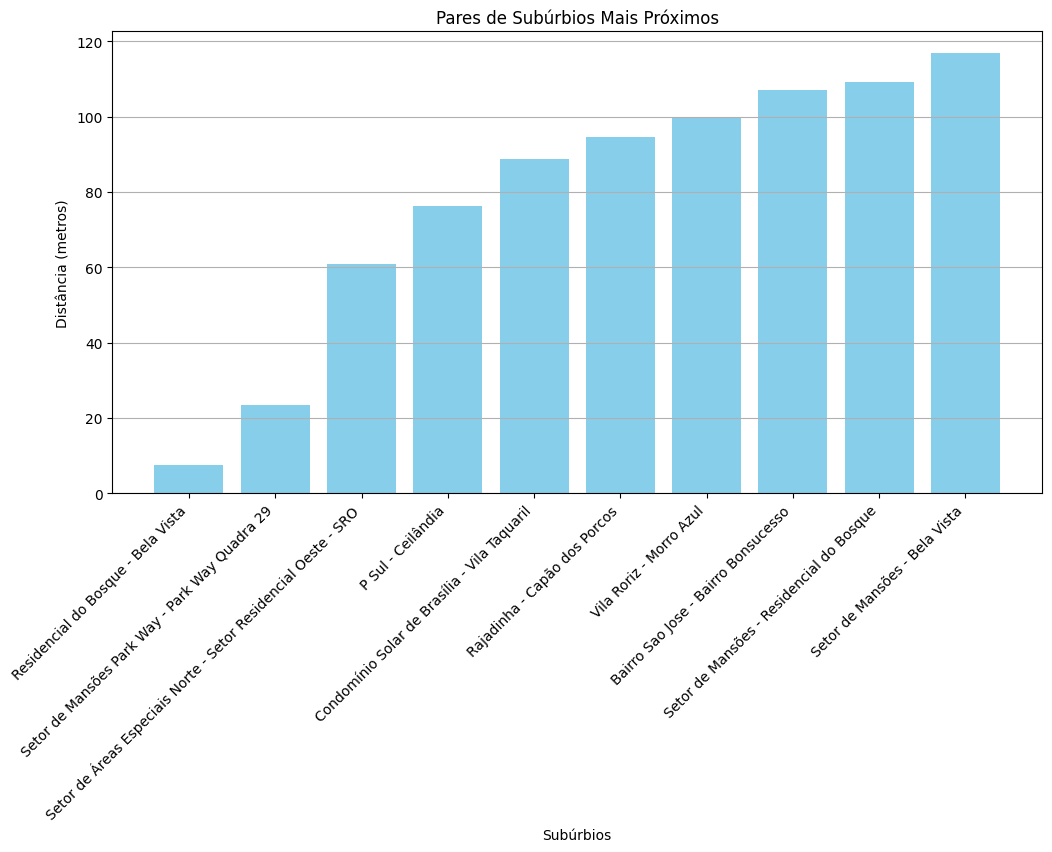

In [19]:
from itertools import combinations

from geopy.distance import geodesic

coordenadas_suburbios = {}
for suburbio in entregas_por_suburbio.index:
    lat = geo_deliveries_df.loc[geo_deliveries_df['delivery_suburb'] == suburbio, 'delivery_lat'].iloc[0]
    lng = geo_deliveries_df.loc[geo_deliveries_df['delivery_suburb'] == suburbio, 'delivery_lng'].iloc[0]
    coordenadas_suburbios[suburbio] = (lat, lng)

distancias_entre_suburbios = {}
for suburbio1, suburbio2 in combinations(entregas_por_suburbio.index, 2):
    distancia = geodesic(coordenadas_suburbios[suburbio1], coordenadas_suburbios[suburbio2]).meters
    distancias_entre_suburbios[(suburbio1, suburbio2)] = distancia

df_distancias = pd.DataFrame(list(distancias_entre_suburbios.items()), columns=['suburbio_pair', 'distancia_metros'])

df_distancias[['suburbio1', 'suburbio2']] = pd.DataFrame(df_distancias['suburbio_pair'].tolist(), index=df_distancias.index)

df_distancias.drop('suburbio_pair', axis=1, inplace=True)

suburbios_mais_proximos = df_distancias.nsmallest(10, 'distancia_metros')

plt.figure(figsize=(12, 6))
plt.bar(suburbios_mais_proximos['suburbio1'] + ' - ' + suburbios_mais_proximos['suburbio2'], suburbios_mais_proximos['distancia_metros'], color='skyblue')
plt.title('Pares de Subúrbios Mais Próximos')
plt.xlabel('Subúrbios')
plt.ylabel('Distância (metros)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


A comparação entre os dois mapas revela uma perspectiva valiosa sobre a distribuição das entregas em relação à capacidade de utilização dos veículos. Enquanto o primeiro mapa fornece uma visão regional das entregas em relação aos hubs da empresa, o segundo mapa enriquece essa visualização ao adicionar a localização exata dos subúrbios e suas respectivas porcentagens de utilização de capacidade.

Essa abordagem permite uma análise mais detalhada e granular das áreas com baixa utilização dos veículos. Ao identificar esses subúrbios específicos e suas porcentagens de utilização reduzida, a empresa pode direcionar esforços para otimizar as operações nessas áreas. Isso pode envolver estratégias como o redimensionamento de rotas, a consolidação de entregas em determinadas regiões ou a revisão dos métodos de alocação de recursos.

Além disso, ao visualizar as entregas em relação aos hubs e subúrbios, a empresa pode identificar padrões geográficos e oportunidades de melhoria na distribuição de recursos e na eficiência operacional. Essa análise comparativa dos mapas fornece uma visão holística da logística da empresa, permitindo a implementação de medidas específicas para melhorar a utilização dos veículos e otimizar o serviço de entrega como um todo.

<ipython-input-21-002c794da5f0>:20: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


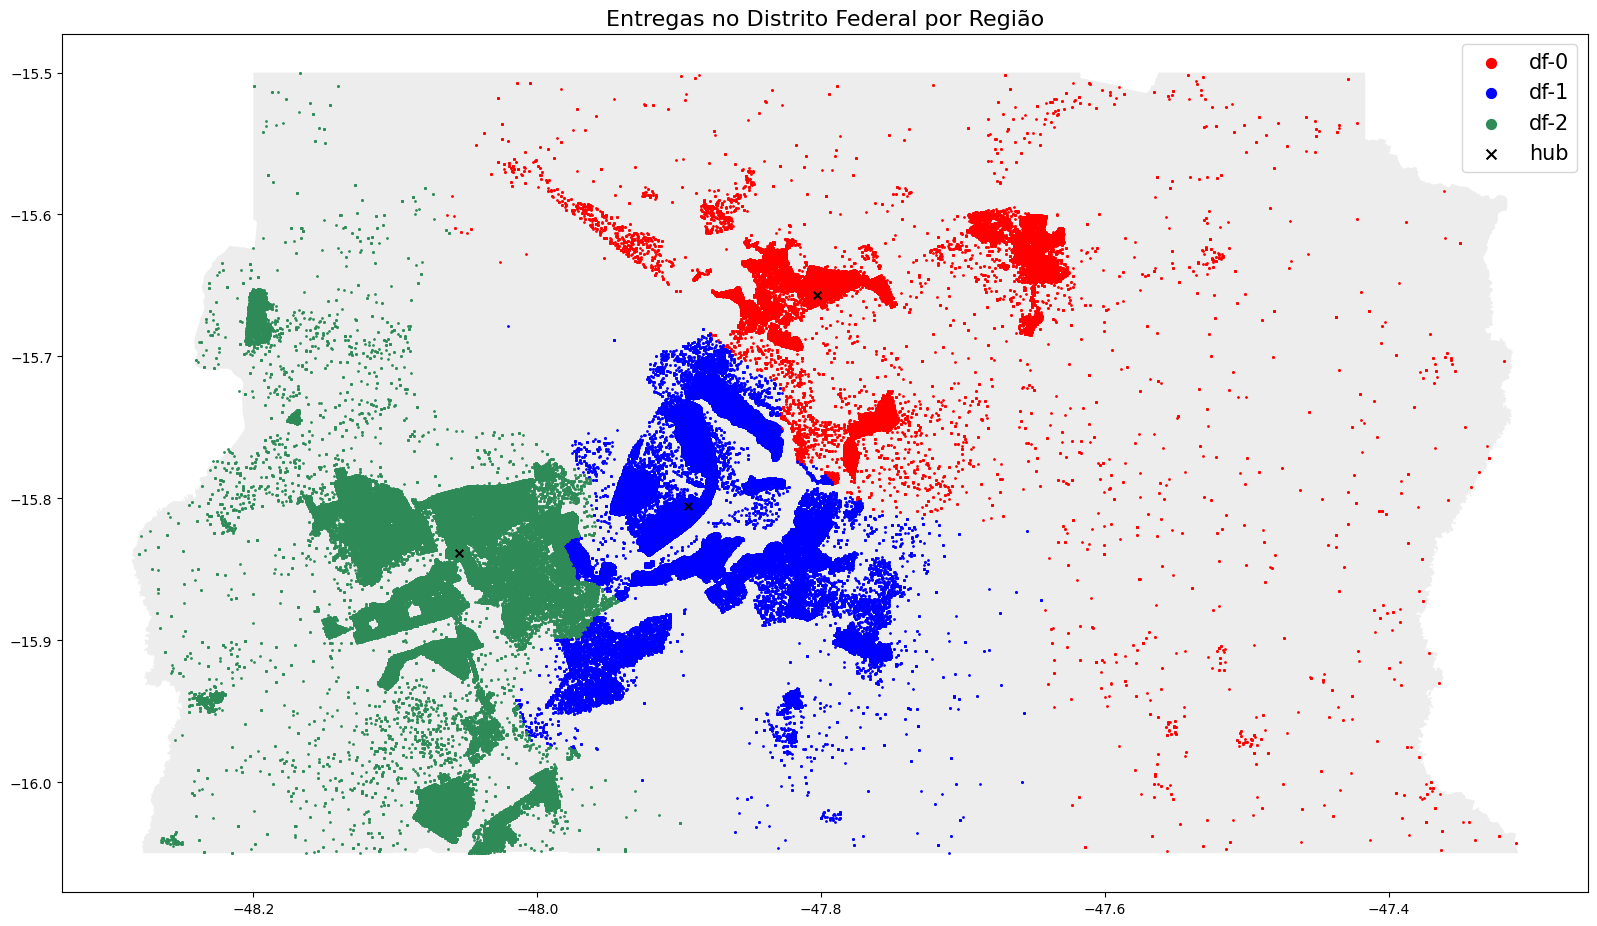

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

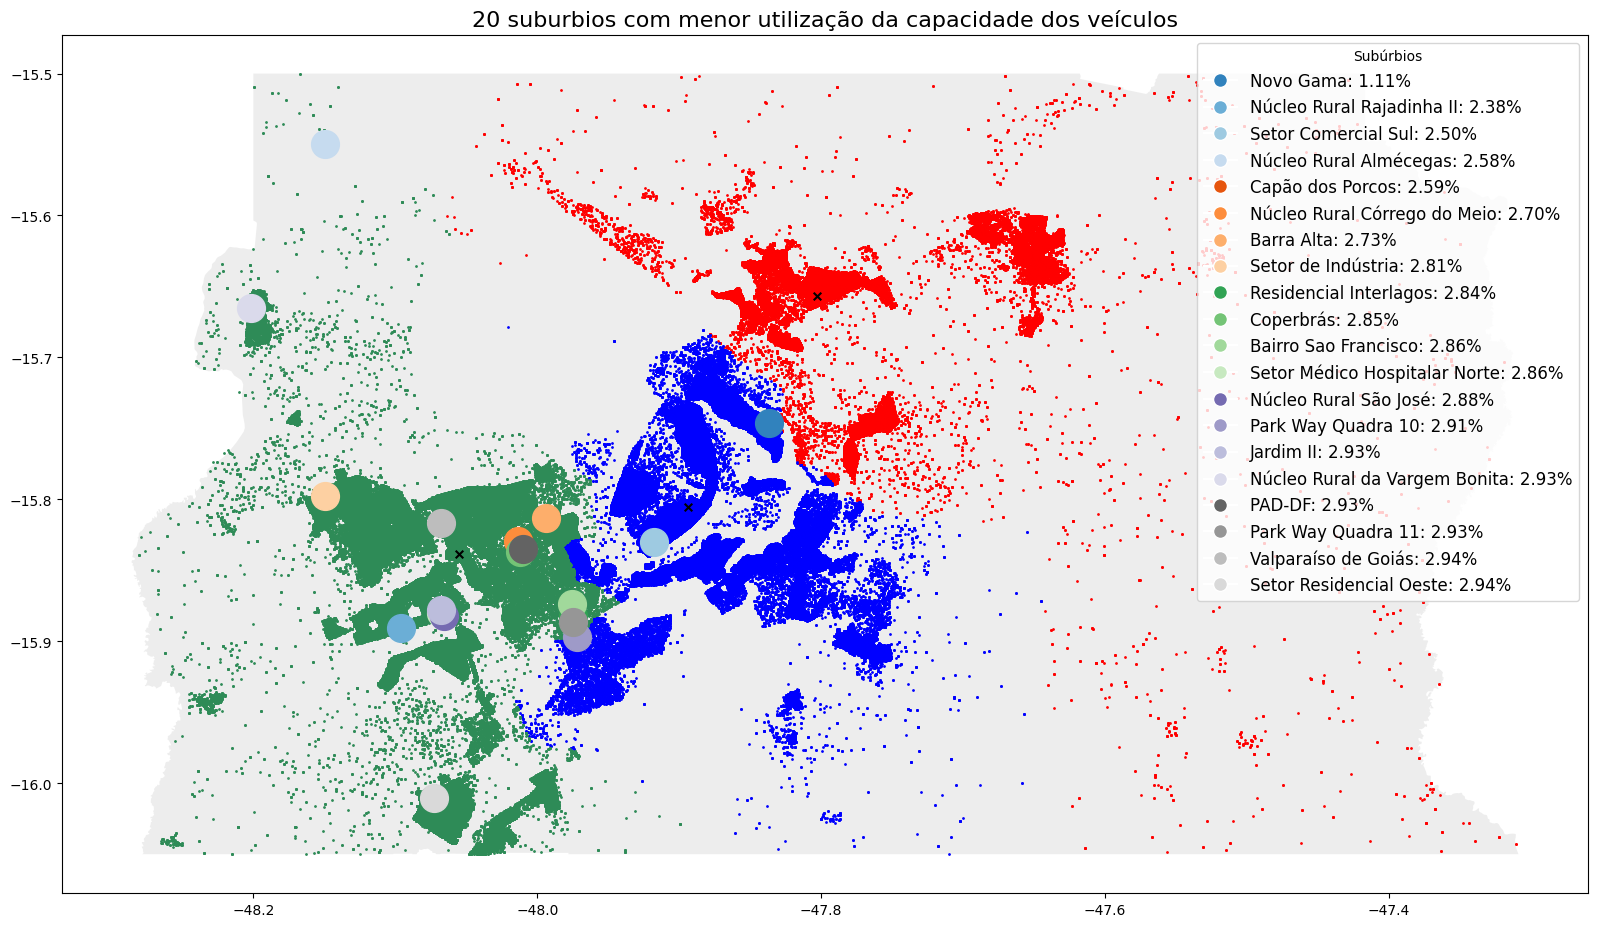

In [22]:
fig, ax = plt.subplots(figsize=(50/2.54, 50/2.54))

mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

plt.title("20 suburbios com menor utilização da capacidade dos veículos", fontdict={"fontsize": 16})

geo_deliveries_df['aproveitamento_capacidade'] = geo_deliveries_df['delivery_size'] / geo_deliveries_df['vehicle_capacity']

top_20_suburbios_menor_aproveitamento = geo_deliveries_df.groupby('delivery_suburb')['aproveitamento_capacidade'].mean().nsmallest(20)

cores_legenda = plt.cm.tab20c(np.linspace(0, 1, len(top_20_suburbios_menor_aproveitamento)))

labels = [f"{suburbio}: {aproveitamento*100:.2f}%" for suburbio, aproveitamento in top_20_suburbios_menor_aproveitamento.items()]

for i, (suburbio, aproveitamento) in enumerate(top_20_suburbios_menor_aproveitamento.items()):
    coordenadas_suburbio = geo_deliveries_df.loc[geo_deliveries_df['delivery_suburb'] == suburbio, ['delivery_lat', 'delivery_lng']].iloc[0]
    latitude = coordenadas_suburbio['delivery_lat']
    longitude = coordenadas_suburbio['delivery_lng']

    ax.plot(longitude, latitude, marker='o', color=cores_legenda[i], markersize=20)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cores_legenda[i], markersize=10, label=label) for i, label in enumerate(labels)]
plt.legend(handles=handles, title='Subúrbios', loc='upper right', fontsize=12)

plt.show()

A visualização no último mapa, que destaca a localização dos 20 subúrbios com a menor utilização da capacidade dos veículos, oferece uma precisão ainda maior para um estudo mais avançado e direcionado. Ao identificar especificamente essas áreas com baixa eficiência de utilização dos veículos, a empresa pode concentrar seus esforços de análise e intervenção nessas regiões específicas.

Essa abordagem permite uma investigação mais detalhada das causas subjacentes à baixa utilização dos veículos, como padrões de demanda, infraestrutura de transporte, condições de tráfego e distribuição geográfica da clientela. Com uma compreensão mais profunda desses fatores, a empresa pode desenvolver estratégias mais precisas e eficazes para otimizar as operações nessas áreas.

In [23]:
geo_deliveries_df['aproveitamento_capacidade'] = geo_deliveries_df['delivery_size'] / geo_deliveries_df['vehicle_capacity']

top_20_suburbios_menor_aproveitamento = geo_deliveries_df.groupby('delivery_suburb')['aproveitamento_capacidade'].mean().nsmallest(20)

mapa = folium.Map(location=[-23.5505, -46.6333], zoom_start=10)

for suburbio, aproveitamento in top_20_suburbios_menor_aproveitamento.items():
    coordenadas_suburbio = geo_deliveries_df.loc[geo_deliveries_df['delivery_suburb'] == suburbio, ['delivery_lat', 'delivery_lng']].iloc[0]
    latitude = coordenadas_suburbio['delivery_lat']
    longitude = coordenadas_suburbio['delivery_lng']
    marker = folium.Marker(location=[latitude, longitude], popup=f"{suburbio}: Aproveitamento {aproveitamento}")
    mapa.add_child(marker)

mapa